# Fisheries demonstrator

In [9]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import sys, os
from affine import Affine
import numpy as np
import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
#import hvplot.xarray
import geoviews as gv

In [10]:
import zipfile as zip
import tempfile
import cdsapi
import netCDF4 as nc

# Mapping changes for a single species.

We can map changes for a single species using xarray and cartopy. We will do this for the abundance of mackeral and RCP 8.5 and 0.8 * MSY.

Download the fish abundance data from the CDS. Although we interested in mackerel initialy, we download all the species now as we use them later.

In [11]:
species = ['sole', 'anchovie', 'plaice', 'atlantic_halibut', 'red_mullet',
       'atlantic_horse_mackerel', 'turbot', 'atlantic_salmon',
       'veined_squid', 'blue_whiting', 'bluefin_tuna', 'capelin', 'cod',
       'saithe', 'common_cuttlefish', 'dab', 'dolphinfish', 'sardine',
       'european_seabass', 'european_sprat', 'european_squid', 'shrimp',
       'gilt_head_seabream', 'haddock', 'hake', 'herring', 'mackerel',
       'meagre']
msy = "08"
rcp = "85"
zipname = 'SS_DBEM_POLCOMS_fish_abundance-all-rcp' + rcp +'-msy' + msy + '08-' + fishname + '-v0.1.zip'

In [12]:
with tempfile.TemporaryDirectory() as tmpdirname:
    #print('created temporary directory', tmpdirname)
    c = cdsapi.Client(url='https://cds-dev.copernicus-climate.eu/api/v2', key='307:95ac04a3-0aed-40a1-96be-4f4bd131d449')

    c.retrieve(
        'sis-fish-abundance',
        {
            'format':'zip',
            'model':'ss_dbem_polcoms',
            'variable':['species_abundance','species_catch'],
            'experiment':'rcp85',
            'maximum_sustainable_yield':'08',
            'species':species
        },
        tmpdirname + '/' + zipname)
    with zip.ZipFile(tmpdirname + '/' + zipname) as myzip:
        myzip.extractall('SS_DBEM_POLCOMS_fish_abundance')
    #load abundance data (abd) and catch data (catch) dataset
    #abd = nc.Dataset(tmpdirname + '/' + abdname)
    #catch = nc.Dataset(tmpdirname + '/' + ctchname)
    #species_data = xr.open_dataset(tmpdirname + '/' + abdname)

2019-09-11 11:07:11,225 INFO Sending request to https://cds-dev.copernicus-climate.eu/api/v2/resources/sis-fish-abundance
/opt/conda/lib/python3.7/site-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
2019-09-11 11:07:16,503 INFO Request is completed
2019-09-11 11:07:16,504 INFO Downloading http://136.156.132.79/cache-compute-0000/cache/data2/dataset-sis-fish-abundance-8169ff3d-630a-4132-9b7b-c35b6a61561a.zip to /tmp/tmpe2pkvd7k/SS_DBEM_POLCOMS_fish_abundance-all-rcp85-msy0808-red_mullet-v0.1.zip (28.5M)
2019-09-11 11:07:17,090 INFO Download rate 48.7M/s
/opt/conda/lib/python3.7/site-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/

The first step is to read in the file using xarray.

In [13]:
ff = 'SS_DBEM_POLCOMS_fish_abundance/SS_DBEM_POLCOMS_fish_abundance-abundance-rcp85-msy08-mackerel-v0.1.nc'
species_data = xr.open_dataset(ff)

We then need to calculate a climatology for today and the future. We start by defining the baseline, i.e. present day period, and the future period for any comparisons.

In [14]:
baseline_period = [2006, 2009]
future_period = [2090, 2099]

We then need to calculate a climatology for the two time periods. This can be done quickly using xarray.

In [15]:
baseline_climatology = (species_data.sel(time=species_data.time.dt.year.isin(baseline_period))
        .abundance
        .mean(dim = ["time"])
        )
future_climatology = (species_data.sel(time=species_data.time.dt.year.isin(future_period))
        .abundance
        .mean(dim = ["time"])
        )

/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


At this point we need to create a new xarray data set showing the relative changes in abundance.

In [16]:
species_changes = 100 * (future_climatology / baseline_climatology- 1)

We can then map the changes using xarray and cartopy.

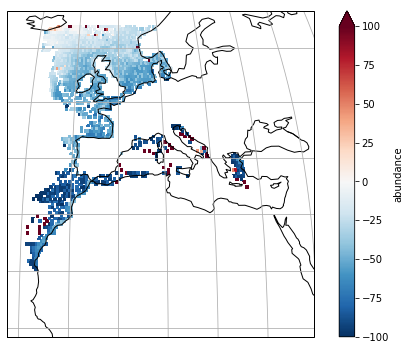

In [17]:

fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
ax.gridlines()
species_changes.plot(ax=ax, transform=ccrs.PlateCarree(),
          vmax=100)

In [18]:
species_changes

<xarray.DataArray 'abundance' (latitude: 107, longitude: 112)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [       nan, -51.468372, -36.31211 , ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 11.25 11.75 12.25 12.75 ... 63.25 63.75 64.25
  * longitude  (longitude) float32 -19.25 -18.75 -18.25 ... 35.25 35.75 36.25

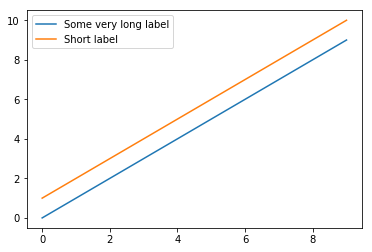

In [19]:
plt.plot(range(10), label='Some very long label')
plt.plot(range(1,11), label='Short label')
L=plt.legend()

# Mapping geographic subregions

We can map changes in geographic subregions, either specific lat/lon boxes or aggregations of ICES areas.

If we want to map a specific lon/lat box we can define lonlat ranges and then clip the xarray data set before plotting it. Here, we will map changes in mackeral abundance around the British Isles.

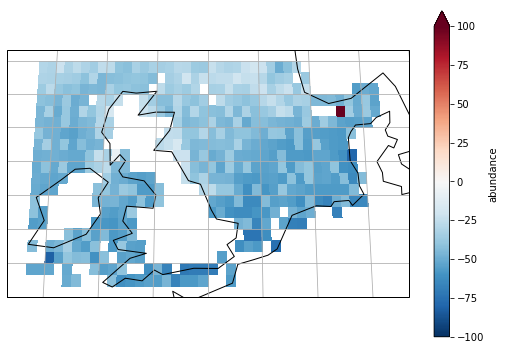

In [20]:
lon_range = [-10, 10]
lat_range = [50, 60]
box_changes = species_changes.sel(latitude = slice(lat_range[0], lat_range[1]))
box_changes = box_changes.sel(longitude = slice(lon_range[0], lon_range[1]))

fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
ax.gridlines()
box_changes.plot(ax=ax, transform=ccrs.PlateCarree(),
          vmax=100)

We can map changes in aggregated ICES regions as follow.

First, we need to read in an xarray data set of all of the ICES areas.

In [28]:
ices_xr = xr.open_dataset("../../data/fisheries/ices_regions.nc")

In this example we will map changes in mackeral for the ICES areas covering the North Sea. In theory we can do this for any collection.

In [29]:
ices_areas = ["IVa", "IVb", "IVc"]

We then need to merge this with the species_changes data set. Once that is done we can use the where command to select the

In [30]:
species_changes_ices = xr.merge([species_changes, ices_xr])
species_changes_ices = species_changes_ices.where(species_changes_ices.Area.isin(ices_areas))
species_changes_ices = species_changes_ices.drop("Area")

We are now able to map changes for the selected ICES areas.

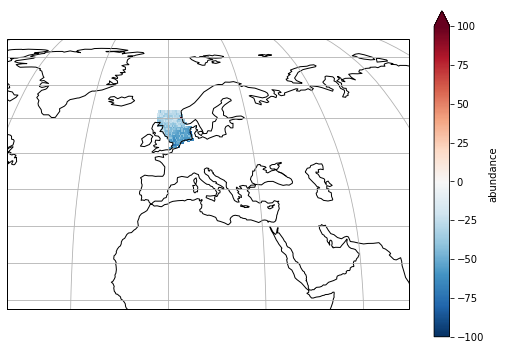

In [31]:
fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
ax.gridlines()
species_changes_ices.abundance.plot(ax=ax, transform=ccrs.PlateCarree(),
          vmax=100)

This will plot a much larger region than required. So we will need to clip the area to the ICES region.

In [32]:
ices_df = ices_xr.to_dataframe().query("Area in @ices_areas").reset_index()
species_changes_ices = (
    species_changes_ices
    .sel(longitude = slice(min(ices_df.longitude), max(ices_df.longitude)))
    .sel(latitude = slice(min(ices_df.latitude), max(ices_df.latitude)))
)


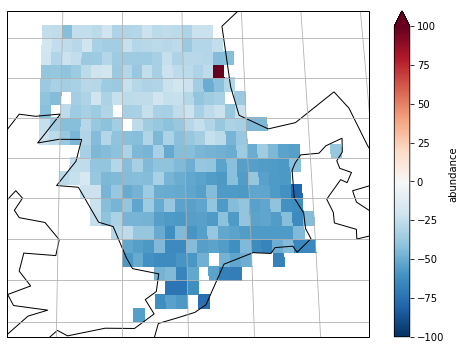

In [33]:
fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
ax.gridlines()
species_changes_ices.abundance.plot(ax=ax, transform=ccrs.PlateCarree(),
          vmax=100)

# Aggregated outputs


We can calculate a number of aggregated metrics. For example, changes in benthic communities etc.

The first step in calculating the aggregated changes is to create a data frame which lists all available outputs and contains key metadata.

In [39]:
data_dir = "SS_DBEM_POLCOMS_fish_abundance"
file_paths = [os.path.join(dp, f) for dp, dn, filenames in os.walk(data_dir) for f in filenames if os.path.splitext(f)[1] == '.nc']
file_paths = pd.DataFrame({"path": file_paths})
df_metrics = file_paths["path"].str.split("\\/", expand = True)

In [40]:
df_metrics = df_metrics[1].str.split("-", expand = True)

In [41]:
file_paths["rcp"] = df_metrics[2]
file_paths["msy"] = df_metrics[3]
file_paths["metric"] = df_metrics[1]
#file_paths["species"] = pd.Series(list((x.replace("-v0.1.nc", "") for x in df_metrics[11]))).str.split("-", expand = True)[4]
file_paths["species"] = df_metrics[4]
file_paths["species"] = file_paths["species"].str.replace("_", " ")
file_paths = file_paths.loc[:, ["species", "rcp", "metric", "msy", "path"]]
#del data_dir, df_metrics

We now have a data frame which contains all relevant information on the output available.

In [42]:
file_paths.head()

,species,rcp,metric,msy,path
0,herring,rcp85,abundance,msy08,SS_DBEM_POLCOMS_fish_abundance/SS_DBEM_POLCOMS...
1,atlantic horse mackerel,rcp85,catch,msy08,SS_DBEM_POLCOMS_fish_abundance/SS_DBEM_POLCOMS...
2,sardine,rcp85,abundance,msy08,SS_DBEM_POLCOMS_fish_abundance/SS_DBEM_POLCOMS...
3,atlantic halibut,rcp85,catch,msy08,SS_DBEM_POLCOMS_fish_abundance/SS_DBEM_POLCOMS...
4,anchovie,rcp85,abundance,msy08,SS_DBEM_POLCOMS_fish_abundance/SS_DBEM_POLCOMS...


And we can then list all available species.


In [43]:
species_list = file_paths.species.drop_duplicates()
species_list.values

array(['herring', 'atlantic horse mackerel', 'sardine',
       'atlantic halibut', 'anchovie', 'blue whiting', 'mackerel',
       'haddock', 'red mullet', 'bluefin tuna', 'plaice', 'shrimp',
       'european squid', 'veined squid', 'turbot', 'dab',
       'common cuttlefish', 'capelin', 'meagre', 'saithe',
       'european sprat', 'sole', 'dolphinfish', 'european seabass',
       'gilt head seabream', 'hake', 'atlantic salmon', 'cod'],
      dtype=object)

## Guild level changes

To calculate guild level changes, we first need to read in the guilds from a csv file and create a data frame showing which species is pelagic etc.

In [54]:
species_guilds = pd.read_csv("../../data/fisheries/species_guilds.csv")
species_guilds["species"] = species_guilds["species"].str.lower()
species_guilds = pd.DataFrame({"species": species_list}).merge( species_guilds, how = "left").drop(columns = "note")

We are then able to map changes in abundance and catch across all available dimensions.

We will do this by wrapping the code used for a single species into a function that can handle multiple species.

By default this function uses 2006-2010 and 2090-2099 as the periods for comparison.

In [55]:
def guild_changes(guild_choice = None, msy_choice = None, metric_choice = None ,
    rcp_choice = None, ices_areas = None, lat_range = None, lon_range = None):

    files = file_paths.query('rcp == @rcp_choice and msy == @msy_choice and metric == @metric_choice')
    files = files.merge(species_guilds).query("guild == @guild_choice")
        
    all_values = []
    
    for i in list(range(len(files))):
        ff = files["path"].iloc[i]
        species = files["species"].iloc[i]
        i_values = (
            xr.open_dataset(ff)
        )
        data = i_values.copy()
        i_values.close()
        if lat_range is not None:
            data = data.sel(latitude = slice(lat_range[0], lat_range[1]))
        
        if lon_range is not None:
            data = data.sel(longitude = slice(lon_range[0], lon_range[1]))
        if ices_areas is not None:   
            data = xr.merge([data, ices_xr])
            data = data.where(data.Area.isin(ices_areas))
            data = data.drop("Area")
            min_lon = ices_xr.to_dataframe().reset_index().query("Area in @ices_areas").longitude.min()
            min_lat = ices_xr.to_dataframe().reset_index().query("Area in @ices_areas").latitude.min()
            max_lon = ices_xr.to_dataframe().reset_index().query("Area in @ices_areas").longitude.max()
            max_lat = ices_xr.to_dataframe().reset_index().query("Area in @ices_areas").latitude.max()
            data = data.sel(longitude = slice(min_lon, max_lon))
            data = data.sel(latitude = slice(min_lat, max_lat))
            
        all_values.append(data)
    
    all_values = xr.concat(all_values)
    if metric_choice == "abundance":
        baseline_climatology = (all_values.sel(time=all_values.time.dt.year.isin([2006,2010]))
                .abundance
                .sum(dim = ["concat_dims"])
                .mean(dim = ["time"])
                )
        future_climatology = (all_values.sel(time=all_values.time.dt.year.isin([2090,2099]))
                .abundance
                .sum(dim = ["concat_dims"])
                .mean(dim = ["time"])
                )
    else:
    
        baseline_climatology = (all_values.sel(time=all_values.time.dt.year.isin([2006,2010]))
                .catch
                .sum(dim = ["concat_dims"])
                .mean(dim = ["time"])
                )
        future_climatology = (all_values.sel(time=all_values.time.dt.year.isin([2090,2099]))
                .catch
                .sum(dim = ["concat_dims"])
                .mean(dim = ["time"])
                )
    change = 100 * (future_climatology / baseline_climatology- 1)
    return change


We can then map changes in the benthic species biomass.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: the `dim` argument to `concat` will be required in a future version of xarray; for now, setting it to the old default of 'concat_dim'


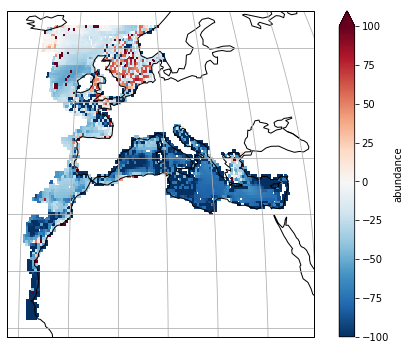

In [56]:
changes = guild_changes(guild_choice = "benthic", msy_choice = "msy08", metric_choice = "abundance" ,
    rcp_choice = "rcp85" )
fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
ax.gridlines()
changes.plot(ax=ax, transform=ccrs.PlateCarree(),
          vmax=100)

Changes in demersal species biomass

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: the `dim` argument to `concat` will be required in a future version of xarray; for now, setting it to the old default of 'concat_dim'


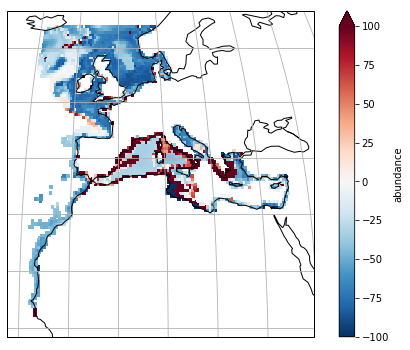

In [57]:

changes = guild_changes(guild_choice = "demersal", msy_choice = "msy08", metric_choice = "abundance" ,
    rcp_choice = "rcp85" )
fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
ax.gridlines()
changes.plot(ax=ax, transform=ccrs.PlateCarree(),
          vmax=100)

Changes in pelagic species biomass

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: the `dim` argument to `concat` will be required in a future version of xarray; for now, setting it to the old default of 'concat_dim'


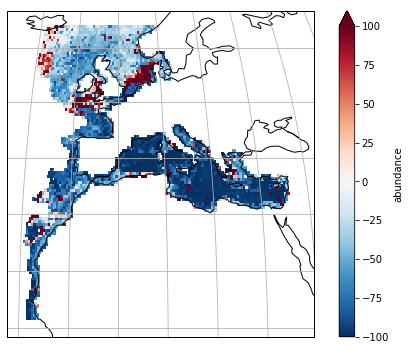

In [58]:

changes = guild_changes(guild_choice = "pelagic", msy_choice = "msy08", metric_choice = "abundance" ,
    rcp_choice = "rcp85" )
fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
ax.gridlines()
changes.plot(ax=ax, transform=ccrs.PlateCarree(),
          vmax=100)

Changes in shellfish biomass

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: the `dim` argument to `concat` will be required in a future version of xarray; for now, setting it to the old default of 'concat_dim'


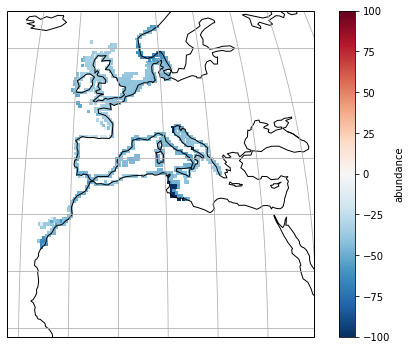

In [59]:

changes = guild_changes(guild_choice = "shellfish", msy_choice = "msy08", metric_choice = "abundance" ,
    rcp_choice = "rcp85" )
fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
ax.gridlines()
changes.plot(ax=ax, transform=ccrs.PlateCarree(),
          vmax=100)

Changes in potential benthic species catch.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: the `dim` argument to `concat` will be required in a future version of xarray; for now, setting it to the old default of 'concat_dim'


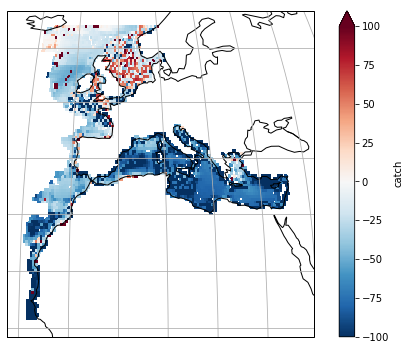

In [60]:
changes = guild_changes(guild_choice = "benthic", msy_choice = "msy08", metric_choice = "catch" ,
    rcp_choice = "rcp85" )
fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
ax.gridlines()
changes.plot(ax=ax, transform=ccrs.PlateCarree(),
          vmax=100)

Changes in potential demersal species catch.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: the `dim` argument to `concat` will be required in a future version of xarray; for now, setting it to the old default of 'concat_dim'


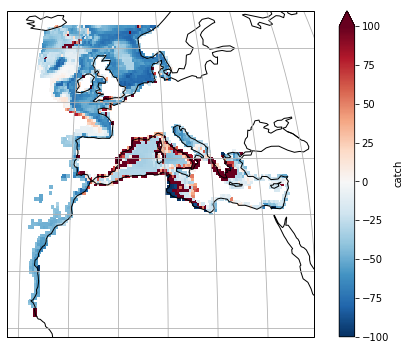

In [61]:
changes = guild_changes(guild_choice = "demersal", msy_choice = "msy08", metric_choice = "catch" ,
    rcp_choice = "rcp85" )
fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
ax.gridlines()
changes.plot(ax=ax, transform=ccrs.PlateCarree(),
          vmax=100)

Changes in pelagic species catch.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: the `dim` argument to `concat` will be required in a future version of xarray; for now, setting it to the old default of 'concat_dim'


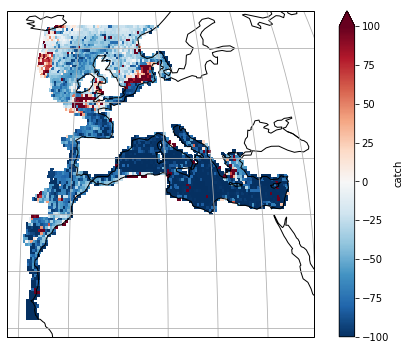

In [62]:
changes = guild_changes(guild_choice = "pelagic", msy_choice = "msy08", metric_choice = "catch" ,
    rcp_choice = "rcp85" )
fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
ax.gridlines()
changes.plot(ax=ax, transform=ccrs.PlateCarree(),
          vmax=100)

Changes in potential shellfish species catch.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: the `dim` argument to `concat` will be required in a future version of xarray; for now, setting it to the old default of 'concat_dim'


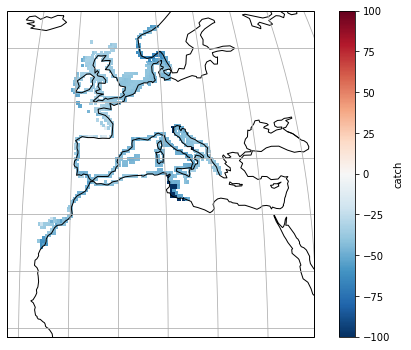

In [63]:
changes = guild_changes(guild_choice = "shellfish", msy_choice = "msy08", metric_choice = "catch" ,
    rcp_choice = "rcp85" )
fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
ax.gridlines()
changes.plot(ax=ax, transform=ccrs.PlateCarree(),
          vmax=100)

# Intrinsic vulnerability index of the catch

Species vulnerabilities are calculated based on the vulnerabilities listed in the appendix from [Intrinsic vulnerability in the global fish catch, Cheung et al., 2007](https://www.int-res.com/abstracts/meps/v333/p1-12/).

During each year a weighted average of the vulnerability is calculated using the equation:

$$\frac{\sum_{i=1}^{28}(\text{Vulnerability}_i * \text{Catch}_i)}{\sum_{i=1}^{28} \text{Catch}_i} $$


The vulnerabilities of each species provided by Cheung et al. have been converted to a pandas data frame that can be read in from a feather file.

In [64]:
species_codes = (pd.read_excel("../../data/fisheries/fish-species-taxon-list.xlsx")
 .rename(columns = {"Common name": "species", "Latin name":"scientific"})
                )
species_codes["species"] = species_codes.species.str.lower().str.strip().str.replace("-", " ")

species_info = (pd.merge(pd.DataFrame({"species":species_list}), species_codes, how = "left")
 .drop_duplicates())

species_info["scientific"] = species_info.scientific.str.strip()
vulnerabilities = (pd.read_feather("../../data/fisheries/species_vulnerabilities.feather")
 .rename(columns = {"species": "scientific"})
)
species_vulnerabilities = pd.merge(species_info, vulnerabilities, how = "left").dropna()

del species_codes, species_info



We now have a data frame with the species vulnerabilities.

In [65]:
species_vulnerabilities.head()

,species,scientific,Taxon code,vulnerability
0,herring,Clupea harengus,600024,53.0
1,atlantic horse mackerel,Trachurus trachurus,601365,46.0
2,sardine,Sardina pilchardus,601350,49.0
3,atlantic halibut,Hippoglossus hippoglossus,601371,68.0
4,anchovie,Engraulis encrasicolus,600066,44.0


We are now able to read in catch for each species and each year and then calculate the weighted average vulnerability.

First, we need to create a pandas data frame with catch for each species and year. To do this we loop through each file, reading the data in using xarray and then converting it to a data frame. A list is created with all of the data, which is then concatenated to a single data frame.

In [66]:
files = file_paths.query('rcp == "rcp85" and msy == "msy08" and metric == "catch"')

all_catch = []

for i in list(range(len(files))):
    ff = files.path.iloc[i]
    species = files.species.iloc[i]
    i_catch = (
        xr.open_dataset(ff).catch.sum(dim = ["longitude", "latitude"]).to_dataframe()
        .reset_index()
        .assign(year = lambda x: x.time.dt.year)
        .assign(species = lambda x: species)
    )
    all_catch.append(i_catch)

all_catch = pd.concat(all_catch)


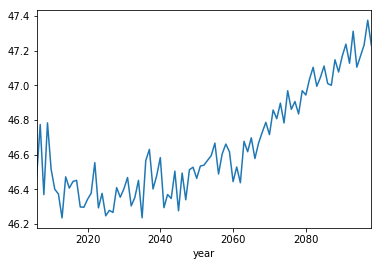

In [67]:
all_catch["species"] = all_catch.species.str.lower().str.strip().str.replace("-", " ")
(
pd.merge(all_catch, species_vulnerabilities)
 .groupby("year")
 .apply(lambda x: sum(x.catch*x.vulnerability)/sum(x.catch))
 .plot()
)

# Kempton diversity metrics

Community diversity was calculated using the Kempton Q diversity metric.

$$Q = \frac{S}{2log(N_{0.25S}/N_{0.75S})}  $$

where $S$ is the total number of species modelled (28) and $N_{0.25S}$ and $N_{0.75S}$ are the representative biomass values of the 25th and 75th percentiles in the cumulative abundance distribution.

Kempton diversity can be calculated for any of the combinations of RCP, MSY and for catch or abundance. Here we show the method for RCP 8.5, msy 0.8 and for abundance.

The first step is to read in all of the data and save it as a data frame.

In [68]:
files = file_paths.query('rcp == "rcp85" and msy == "msy08" and metric == "abundance"')

all_abundance = []

for i in np.arange(0, len(files)):
    ff = files["path"].iloc[i]
    species = files["species"].iloc[i]
    i_abundance = (
        xr.open_dataset(ff)
        .abundance
        .sum(["longitude", "latitude"])
        .to_dataframe()
        .reset_index()
        .assign(year = lambda x: x.time.dt.year)
        .assign(species = lambda x: species)
        .drop(columns = "time")
    )
    all_abundance.append(i_abundance)

all_abundance = pd.concat(all_abundance)

We now need to sort the abundance of the species. Some of the species have na values for abundance, and these are set to zero.

In [69]:
sorted_abundance = (
all_abundance
    .assign(abundance = lambda x: np.where(np.isnan(x.abundance), 0, x.abundance))
    .sort_values("abundance")
)
sorted_abundance["number"] = sorted_abundance.groupby("year").cumcount()+1

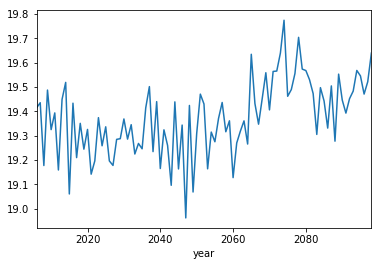

In [70]:
df = sorted_abundance.query("number in [7, 21]").drop(columns = "species")
(
df
    .assign(number = lambda x: np.where(x.number == 7, "lower", "upper"))
    .pivot(index = "year",columns = "number", values = "abundance")
    .assign(Q = lambda x: 28 / (2 * np.log(x.lower)/ np.log(x.upper)))
    .Q
    .plot()
)

# Changes in IUCN Red List endangered species

Two of the species, Atlantic halibut and dolphinfish are classified as endangered in the IUCN Red List. We can modify the above code to be able to both map changes and also generate time series of abundance catch under different scenarios.

We will first show how this can be done for RCP 8.5 and halibut abundance with mys=0.8

As before, the first step is to read the data in as an xarray datset.

In [71]:
ff = "SS_DBEM_POLCOMS_fish_abundance/SS_DBEM_POLCOMS_fish_abundance-abundance-rcp85-msy08-atlantic_halibut-v0.1.nc" 
species_values = (
    xr.open_dataset(ff)
)

We can then map changes for the entire region.

In [72]:
baseline_climatology = (species_values.sel(time=species_values.time.dt.year.isin([2006,2010]))
           .abundance
           .mean(dim = ["time"])
           )
future_climatology = (species_values.sel(time=species_values.time.dt.year.isin([2090,2099]))
        .abundance
        .mean(dim = ["time"])
        )
species_changes = 100 * (future_climatology / baseline_climatology - 1)

/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


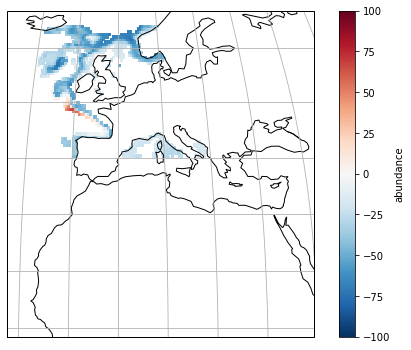

In [73]:
fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
ax.gridlines()
species_changes.plot(ax=ax, transform=ccrs.PlateCarree(),
          vmax=100)

We can also generate time series of abundance

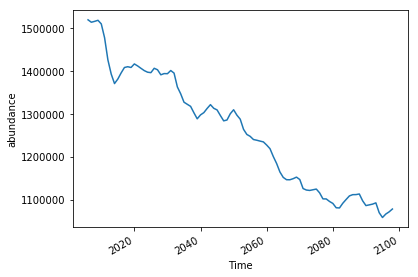

In [74]:
(species_values
 .sum(["longitude", "latitude"])
 .abundance
 .plot()
)

We can then generalize the code above so that we can map the changes for species in specific regions.

In [75]:
def map_species_changes(species_choice = None, msy_choice = None, metric_choice = None ,
    rcp_choice = None, ices_areas = None, lat_range = None, lon_range = None):

    files = file_paths.query('rcp == @rcp_choice and msy == @msy_choice and metric == @metric_choice')
    files = files.query("species == @species_choice")
        
    all_values = []
    
    for i in list(range(len(files))):
        ff = files["path"].iloc[i]
        species = files["species"].iloc[i]
        i_values = (
            xr.open_dataset(ff)
        )
        data = i_values.copy()
        i_values.close()
        if lat_range is not None:
            data = data.sel(latitude = slice(lat_range[0], lat_range[1]))
        
        if lon_range is not None:
            data = data.sel(longitude = slice(lon_range[0], lon_range[1]))
        if ices_areas is not None:   
            data = xr.merge([data, ices_xr])
            data = data.where(data.Area.isin(ices_areas))
            data = data.drop("Area")
            min_lon = ices_xr.to_dataframe().reset_index().query("Area in @ices_areas").longitude.min()
            min_lat = ices_xr.to_dataframe().reset_index().query("Area in @ices_areas").latitude.min()
            max_lon = ices_xr.to_dataframe().reset_index().query("Area in @ices_areas").longitude.max()
            max_lat = ices_xr.to_dataframe().reset_index().query("Area in @ices_areas").latitude.max()
            data = data.sel(longitude = slice(min_lon, max_lon))
            data = data.sel(latitude = slice(min_lat, max_lat))
            
        all_values.append(data)
    
    all_values = xr.concat(all_values)
    if metric_choice == "abundance":
        baseline_climatology = (all_values.sel(time=all_values.time.dt.year.isin([2006,2010]))
                .abundance
                .sum(dim = ["concat_dims"])
                .mean(dim = ["time"])
                )
        future_climatology = (all_values.sel(time=all_values.time.dt.year.isin([2090,2099]))
                .abundance
                .sum(dim = ["concat_dims"])
                .mean(dim = ["time"])
                )
    else:
    
        baseline_climatology = (all_values.sel(time=all_values.time.dt.year.isin([2006,2010]))
                .catch
                .sum(dim = ["concat_dims"])
                .mean(dim = ["time"])
                )
        future_climatology = (all_values.sel(time=all_values.time.dt.year.isin([2090,2099]))
                .catch
                .sum(dim = ["concat_dims"])
                .mean(dim = ["time"])
                )
    species_changes = 100 * (future_climatology / baseline_climatology- 1)
    fig = plt.figure(figsize=(9,6))
    ax = plt.axes(projection=ccrs.Robinson())
    ax.coastlines()
    ax.gridlines()
    species_changes.plot(ax=ax, transform=ccrs.PlateCarree(),vmax=100)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: the `dim` argument to `concat` will be required in a future version of xarray; for now, setting it to the old default of 'concat_dim'


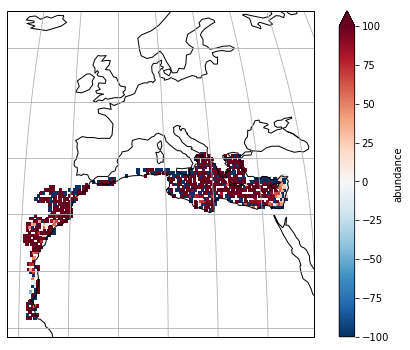

In [76]:
map_species_changes(species_choice = "dolphinfish", rcp_choice = "rcp85", msy_choice = "msy08", metric_choice = "abundance")

In [77]:
def ts_species_changes(species_choice = None, msy_choice = None, metric_choice = None ,
    rcp_choice = None, ices_areas = None, lat_range = None, lon_range = None):

    files = file_paths.query('rcp == @rcp_choice and msy == @msy_choice and metric == @metric_choice')
    files = files.query("species == @species_choice")
        
    all_values = []
    
    for i in list(range(len(files))):
        ff = files["path"].iloc[i]
        species = files["species"].iloc[i]
        i_values = (
            xr.open_dataset(ff)
        )
        data = i_values.copy()
        i_values.close()
        if lat_range is not None:
            data = data.sel(latitude = slice(lat_range[0], lat_range[1]))
        
        if lon_range is not None:
            data = data.sel(longitude = slice(lon_range[0], lon_range[1]))
        if ices_areas is not None:   
            data = xr.merge([data, ices_xr])
            data = data.where(data.Area.isin(ices_areas))
            data = data.drop("Area")
            min_lon = ices_xr.to_dataframe().reset_index().query("Area in @ices_areas").longitude.min()
            min_lat = ices_xr.to_dataframe().reset_index().query("Area in @ices_areas").latitude.min()
            max_lon = ices_xr.to_dataframe().reset_index().query("Area in @ices_areas").longitude.max()
            max_lat = ices_xr.to_dataframe().reset_index().query("Area in @ices_areas").latitude.max()
            data = data.sel(longitude = slice(min_lon, max_lon))
            data = data.sel(latitude = slice(min_lat, max_lat))
            
        all_values.append(data)
    
    all_values = xr.concat(all_values)
    
    (
        all_values
        .sum(["longitude", "latitude"])
        .abundance
        .plot()
    )
    
    


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: the `dim` argument to `concat` will be required in a future version of xarray; for now, setting it to the old default of 'concat_dim'


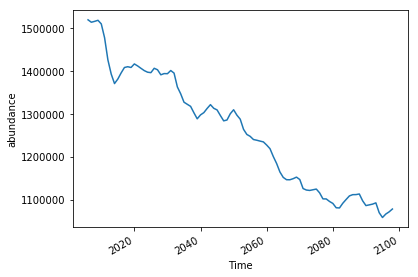

In [78]:
ts_species_changes(species_choice = "atlantic halibut", rcp_choice = "rcp85", msy_choice = "msy08", metric_choice = "abundance")

# Mapping extinction and colonization

In [79]:
ff = "SS_DBEM_POLCOMS_fish_abundance/SS_DBEM_POLCOMS_fish_abundance-abundance-rcp85-msy08-dolphinfish-v0.1.nc" 
species_values = (
    xr.open_dataset(ff)
)


baseline_climatology = (species_values.sel(time=species_values.time.dt.year.isin([2006,2010]))
           .abundance
           .mean(dim = ["time"])
           )
future_climatology = (species_values.sel(time=species_values.time.dt.year.isin([2090,2099]))
        .abundance
        .mean(dim = ["time"])
        )


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [80]:
baseline_climatology = (species_values.sel(time=species_values.time.dt.year.isin([2006,2010]))
#            .abundance
           .mean(dim = ["time"])
           )

future_climatology = (species_values.sel(time=species_values.time.dt.year.isin([2090,2099]))
           .mean(dim = ["time"])
           )

xr.concat([baseline_climatology, future_climatology])


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: the `dim` argument to `concat` will be required in a future version of xarray; for now, setting it to the old default of 'concat_dim'
  # Remove the CWD from sys.path while we load stuff.


<xarray.Dataset>
Dimensions:    (concat_dims: 2, latitude: 107, longitude: 112)
Coordinates:
  * latitude   (latitude) float32 11.25 11.75 12.25 12.75 ... 63.25 63.75 64.25
  * longitude  (longitude) float32 -19.25 -18.75 -18.25 ... 35.25 35.75 36.25
Dimensions without coordinates: concat_dims
Data variables:
    abundance  (concat_dims, latitude, longitude) float32 nan nan ... nan nan

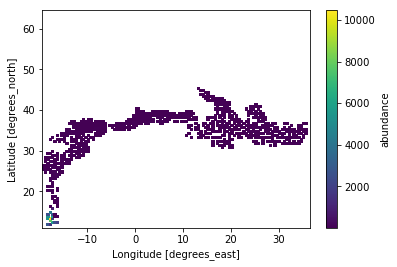

In [81]:

future_climatology.abundance.plot()

In [82]:
baseline_climatology.Present.plot()

AttributeError: 'Dataset' object has no attribute 'Present'

In [ ]:

future_climatology.Future.plot()

In [56]:
species_values = (
    xr.open_dataset(ff)
)
species_values.nbytes/1e6

4.459668